<a href="https://colab.research.google.com/github/unique-subedi/fruit-ripening-experiment/blob/main/Unique_fruit_ripening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
import time
import math
import numpy as np
import scipy
from numpy import linalg as LA
import pandas as pd
import urllib.request
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
from scipy.stats import f_oneway
import random

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/fruit-ripening-experiment/main/data.csv", "data.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/fruit-ripening-experiment/main/banana.csv", "banana.csv")
data = pd.read_csv("data.csv")
banana = pd.read_csv("banana.csv")


## Change in color between the first and the last day of the experiment

Let us define $M_{ij}$ to be the magnitude of pixel for $i^{th}$ banana on $j^{th}$ day of the experiment. Since we ran the experiment for 5 days, we have $j \in \{1, 2, 3,4, 5\}$. In this section, we study the variable 
$$\Delta M_i :=  M_{i1} - M_{i5},$$
that is the change in pixel magnitude between the first and the last day of the experiment for each banana. Similarly, let us denote $G_{ij}$ to be the average green channel value for $i^{th}$ banana on $j^{th}$ day of the experiment. Then, we can define
$$\Delta G_i := G_{i1} - G_{i5}.$$



In [ ]:
df = pd.concat([data, banana.iloc[:,1:]], axis =1)
df_fl = df.loc[:, ['number', 'treatment', '10-19_g', '10-19_magnitude', '10-24_g', '10-24_magnitude']]
df_fl.loc[:, "green_diff"] =   df_fl["10-19_g"] - df_fl["10-24_g"]
df_fl.loc[:, "magnitude_diff"] =  df_fl["10-19_magnitude"] - df_fl["10-24_magnitude"]
df_fl.head()

,number,treatment,10-19_g,10-19_magnitude,10-24_g,10-24_magnitude,green_diff,magnitude_diff
0,1,0,142.200241,201.796117,81.629849,142.617886,60.570392,59.178231
1,2,0,136.596559,194.438883,87.021542,150.442755,49.575017,43.996128
2,3,3,146.216694,206.462037,85.541201,148.156878,60.675493,58.305159
3,4,3,143.395653,191.045587,87.660435,150.752177,55.735218,40.293410
4,5,1,138.321851,180.862401,75.318988,131.585469,63.002863,49.276932


First, we begin by studying if there exist any pair of groups, either treatment-control pair or treatment-treatment pair, for which $\Delta M_i$ or $\Delta G_i$ is statistically different across these two groups in the pair. For this, we use a permutation test using F-statistic as the test statistic. 
Since we have 12 observations across four groups, computing the p-value requires computing test statistics for $12!$ permutations, which is infeasible. So, we compute our p-value using $10000$ randomly generated permutations. The figure below shows the distribution plot of the test statistic under the null hypothesis. Note that the test statistic is always positive, so our test is one-sided.

Text(0.5, 1.0, 'Distribution of F-statistic for change in magnitude')

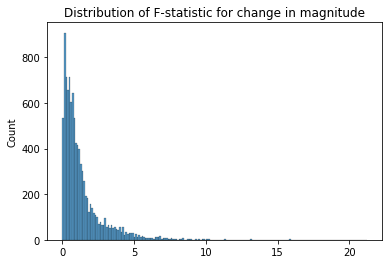

In [ ]:
def F_statistic(y):
  num = 3*y.groupby(level=0).mean().var()
  denom = y.groupby(level=0).var().sum()/4
  return num/denom

def F_test(y):
    F = F_statistic(y)
    #permutations = random.choices(list(itertools.permutations(y.index)), k = 1000)
    hist = []
    initial = y.index
    i = 0
    for i in range(10000):
      y.index = np.random.permutation(initial)
      hist.append(F_statistic(y))
      F_temp = F_statistic(y)
      i+=1
    return np.mean(hist >= F), hist

df_fl.index = df_fl["treatment"]
p_value, hist = F_test(df_fl["magnitude_diff"])
sns.histplot(hist)
plt.title("Distribution of F-statistic for change in magnitude")

We repeat the same F-statistic based permutation test for variable $\Delta G$ as well.

Text(0.5, 1.0, 'Distribution of F-statistic for change in green chanel value')

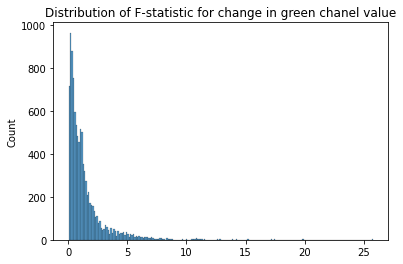

In [ ]:
df_fl.index = df_fl["treatment"]
p_value, hist = F_test(df_fl["green_diff"])
sns.histplot(hist)
plt.title("Distribution of F-statistic for change in green chanel value")

The summary of our tests for both of these variables is presented in the following table.

| Variable    | F-Statistic |p-value      |
| ----------- | ----------- |-------------|
| $\Delta M$  | $5.62$      | $0.02$      |
| $\Delta G$  | $4.84$      | $0.04$      |

Since the p-value is $<0.05$ for both variables $ \Delta M$ and $\Delta G$, our tests suggest that there is at least one pair of groups between which the treatment effect is significant.

Next, we do permutation test on each pair of group separately using difference in means as our test statistic. 

In [ ]:
def permutation_test(data_set, trt1, trt2,  variable):
   data_slice = data_set.loc[data_set.treatment.isin([trt1, trt2])].copy()
   diff_given = data_slice.loc[data_slice.treatment == trt1, variable].mean() - data_slice.loc[data_slice.treatment == trt2, variable].mean()
  
   differences = []
   treatments = data_slice.loc[:, "treatment"].values
   for perms in itertools.permutations(treatments):
     data_slice.loc[:, "treatment"] = perms
     differences.append(data_slice.loc[data_slice.treatment == trt1, variable].mean() - data_slice.loc[data_slice.treatment == trt2, variable].mean())
   return differences, np.mean(differences >= diff_given)
    
    

For instance, the following plot shows the distribution of test statistics while comparing the control group to the treatment group 1 (apple) under the sharp null hypothesis. Since we obtain a p-value to be 0.7, we conclude that the treatment of apple does not have a statistically significant treatment effect.

p-value 0.7


Text(0.5, 1.0, 'p-value for permutation test comparing control group against treatment group 1 (apple)')

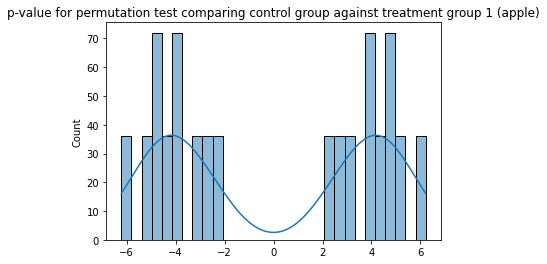

In [ ]:
differences, p_value = permutation_test(df_fl, 0, 1, "green_diff")
print("p-value", p_value)
sns.histplot(differences, bins = 30, kde= True)
plt.title("p-value for permutation test comparing control group against treatment group 1 (apple)")

The p-value of all the tests, where each test compares a treatment group with either control or another treatment group,  is summarized in the following tables.

<table>
<tr>
    <th> </th>
    <th>Control</th>
    <th> Apple </th>
    <th> Cucumber </th> 
    <th> Apple & Cucumber </th> 
</tr>

<tr>
    <th>Control</th> 
    <td>N/A</td> 
    <td> 0.2</td>
    <td> 0.05 </td>
     <td>0.1</td>
</tr>

<tr>
    <th> Apple </th>
    <td> 0.2</td> 
    <td>N/A</td>   
    <td>0.05</td>
     <td>0.4</td>
</tr>

<tr>
    <th> Cucumber </th>
    <td> 0.05 </td> 
    <td>0.05 </td> 
    <td>N/A</td> 
     <td>1.0</td> 
  
</tr>

<tr>
    <th> Apple & Cucumber </th>
    <td> 0.1</td> 
    <td>0.4</td>  
    <td>1.0</td> 
     <td>N/A</td>
</tr>

</table>
<p style="text-align: center;">Table: p-values of permutations tests for variable $\Delta M$</p>


<table>
<tr>
    <th> </th>
    <th>Control</th>
    <th> Apple </th>
    <th> Cucumber </th> 
    <th> Apple & Cucumber </th> 
</tr>

<tr>
    <th>Control</th> 
    <td>N/A</td> 
    <td> 0.7</td>
    <td> 0.05 </td>
     <td>0.3</td>
</tr>

<tr>
    <th> Apple </th>
    <td> 0.7</td> 
    <td>N/A</td>   
    <td>0.05</td>
     <td>0.1</td>
</tr>

<tr>
    <th> Cucumber </th>
    <td> 0.05 </td> 
    <td>0.05 </td> 
    <td>N/A</td> 
     <td>0.9</td> 
  
</tr>

<tr>
    <th> Apple & Cucumber </th>
    <td> 0.3</td> 
    <td>0.1</td>  
    <td>0.9</td> 
     <td>N/A</td>
</tr>

</table>
<p style="text-align: center;">Table: p-values of permutations tests for variable $\Delta G$</p>

As we can see, the p-values of the cucumber treatment group, when compared against the control and apple group, have p-value $0.05$. However, we want to point out that our cucumber was rotten and the bananas got soaked in rotten cucumber juice. We believe that the low p-value was possible because soaked bananas looked darker compared to other bananas. Nevertheless, even with a $0.05$ p-value, after multiple testing adjustments, none of the treatments will be significant. 

Therefore, based on our analysis above, none of our treatments is significant. That is, we did not find any statistical evidence that any of these methods quickens the ripening process.